### Import packages

In [1]:
import networkx as nx
import pandas as pd
from shapely.geometry import Point
import simpy

from opentnsim import core
from opentnsim import lock as lock_module
from opentnsim import graph as graph_module
from opentnsim import output
from opentnsim import vessel as vessel_module
from opentnsim import vessel_traffic_service as vessel_traffic_service_module

# Basic lock simulation
Remember the exercise on the capacity of a lock that was given by Arne van der Hout? Instead of calculating the lock capacity by hand, we can actually simulate locks using the software of OpenTNSim. How does this work?

First, we create an environment

In [2]:
#We have to create a start time for the simulation
simulation_start = pd.Timestamp('2024-01-01')

#Now we create the environment, including the initial_time
env = simpy.Environment(initial_time=simulation_start.timestamp())

#Also we need to add this time to a variable in the environment
env.simulation_start = simulation_start

We need to create a graph and add to the environment

In [3]:
#We need to create a network over which the vessels will sail
node_A = graph_module.Node(name='A',geometry=Point(0,0))
node_B = graph_module.Node(name='B',geometry=Point(400,0))
edges = [(node_A,node_B)]
FG = graph_module.DiGraph(edges=edges,crs='EPSG:28992').graph

#We need to add the graph to the environment:
env.FG = FG

#In order from ships to know where they are going we need to add an VTS to the environment
env.vessel_traffic_service = vessel_traffic_service_module.VesselTrafficService(env=env)

Now we need to create the lock infrastructure

In [4]:
lock = lock_module.IsLockComplex(env=env,
                                 name='Lock I',
                                 start_node='A',
                                 end_node='B',
                                 lock_length = 120,
                                 lock_width = 18,
                                 lock_depth = 6,
                                 lineup_area_A_length=120,
                                 lineup_area_B_length=120,
                                 levelling_time=1500,
                                 distance_doors_A_from_waiting_area_A=140,
                                 distance_doors_B_from_waiting_area_B=140,
                                 distance_waiting_area_A_from_start_node=0,
                                 distance_waiting_area_B_from_end_node=0,
                                 distance_lineup_area_A_to_lock_doors_A=20,
                                 distance_lineup_area_B_to_lock_doors_B=20)

Now we need to add a vessel

In [5]:
#We create a type element that schematisizes a vessel
Vessel = type('Vessel',(lock_module.HasLockComplex, #The vessel should interact with a lock chamber
                        vessel_module.IsVessel),{}) #The vessel should have output

#Using the element, we need to give the following information to the vessel
vessel_I = Vessel(env=env,
                  name='Vessel I', 
                  origin='A',
                  destination='B',
                  type='inland vessel',
                  L=100,
                  B=15,
                  T=5,
                  H=4,
                  v=4,
                  arrival_time=pd.Timestamp('2024-01-01'),)

vessel_II = Vessel(env=env,
                   name='Vessel II', 
                   origin='B',
                   destination='A',
                   type='inland vessel',
                   L=100,
                   B=15,
                   T=5,
                   H=4,
                   v=4,
                   arrival_time=pd.Timestamp('2024-01-01'),)

We can now create a process in the environment in which the vessel will move (from node A to node B)

In [6]:
env.process(vessel_I.move())
env.process(vessel_II.move())

<Process(move) object at 0x18e4132ffd0>

Run the simulation

In [7]:
env.run()

We can now analyse the logbook of the vessel

In [8]:
vessel_df = pd.DataFrame(vessel_I.logbook)
vessel_df

,Message,Timestamp,Value,Geometry
0,Sailing from node A to node B start,2024-01-01 01:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.3135576329102165 47.97476588466147)
1,Sailing to position in line-up area start,2024-01-01 01:00:00.000000,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.3135576329102165 47.97476588466147)
2,Sailing to position in line-up area stop,2024-01-01 01:00:23.333333,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.314494833675866 47.97478336001946)
3,Sailing to end of line-up area start,2024-01-01 01:00:23.333333,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.314494833675866 47.97478336001946)
4,Sailing to end of line-up area stop,2024-01-01 01:01:18.888889,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.3151642631813405 47.97479583773631)
5,Sailing to first set of lock doors start,2024-01-01 01:01:18.888889,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.3151642631813405 47.97479583773631)
6,Sailing to first set of lock doors stop,2024-01-01 01:01:41.111111,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.3154320350738398 47.97480082773064)
7,Sailing to assigned location in lock start,2024-01-01 01:01:41.111111,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.3154320350738398 47.97480082773064)
8,Sailing to assigned location in lock stop,2024-01-01 01:02:58.888889,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.3163692371038613 47.974818287795)
9,Passing lock start,2024-01-01 01:02:58.888889,"{'origin': 'A', 'destination': 'B', 'route': [...",POINT (3.3163692371038613 47.974818287795)


In [9]:
vessel_df = pd.DataFrame(vessel_II.logbook)
vessel_df

,Message,Timestamp,Value,Geometry
0,Sailing from node B to node A start,2024-01-01 01:00:00.000000,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.3189057210154163 47.974865504052005)
1,Sailing to position in line-up area start,2024-01-01 01:00:00.000000,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.318905721015416 47.974865504052005)
2,Sailing to position in line-up area stop,2024-01-01 01:00:23.333333,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.3179685172761793 47.97484806468334)
3,Waiting in line-up area start,2024-01-01 01:00:23.333333,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.3179685172761793 47.97484806468334)
4,Waiting in line-up area stop,2024-01-01 01:29:29.444444,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.3179685172761793 47.97484806468334)
5,Sailing to end of line-up area start,2024-01-01 01:29:29.444444,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.3179685172761793 47.97484806468334)
6,Sailing to end of line-up area stop,2024-01-01 01:30:25.000000,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.3172990864203618 47.97483560330969)
7,Sailing to first set of lock doors start,2024-01-01 01:30:25.000000,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.3172990864203618 47.97483560330969)
8,Sailing to first set of lock doors stop,2024-01-01 01:30:47.222222,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.317031314168243 47.97483061766784)
9,Sailing to assigned location in lock start,2024-01-01 01:30:47.222222,"{'origin': 'B', 'destination': 'A', 'route': [...",POINT (3.317031314168243 47.97483061766784)


and create a time-distance diagram

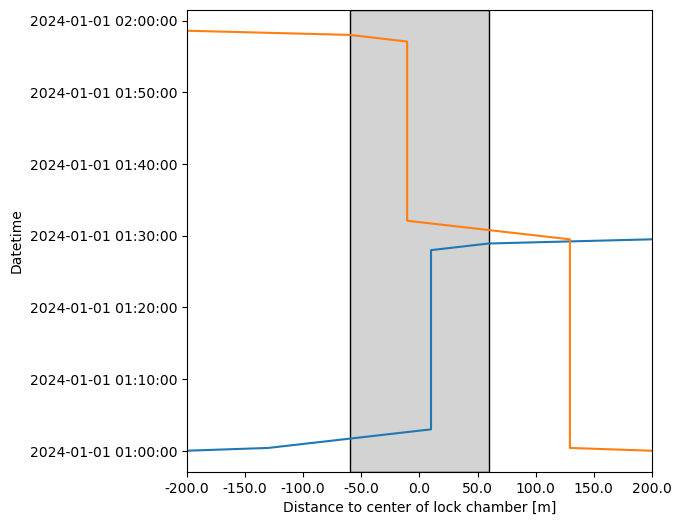

In [10]:
_ = lock.create_time_distance_diagram([vessel_I,vessel_II],vessel_colors=['C0','C1'])

And we can analyse the logbook of the lock

In [11]:
lock_df = pd.DataFrame(lock.logbook)
lock_df

,Message,Timestamp,Value,Geometry
0,Lock doors closing start,2024-01-01 01:02:58.888889,{'visiting_vessels': [<__main__.Vessel object ...,A
1,Lock doors closing stop,2024-01-01 01:02:58.888889,{'visiting_vessels': [<__main__.Vessel object ...,A
2,Lock chamber converting start,2024-01-01 01:02:58.888889,{'visiting_vessels': [<__main__.Vessel object ...,A
3,Lock chamber converting stop,2024-01-01 01:27:58.888889,{'visiting_vessels': [<__main__.Vessel object ...,B
4,Lock doors opening start,2024-01-01 01:27:58.888889,{'visiting_vessels': [<__main__.Vessel object ...,B
5,Lock doors opening stop,2024-01-01 01:27:58.888889,{'visiting_vessels': [<__main__.Vessel object ...,B
6,Lock doors closing start,2024-01-01 01:32:05.000000,{'visiting_vessels': [<__main__.Vessel object ...,B
7,Lock doors closing stop,2024-01-01 01:32:05.000000,{'visiting_vessels': [<__main__.Vessel object ...,B
8,Lock chamber converting start,2024-01-01 01:32:05.000000,{'visiting_vessels': [<__main__.Vessel object ...,B
9,Lock chamber converting stop,2024-01-01 01:57:05.000000,{'visiting_vessels': [<__main__.Vessel object ...,A
